In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['figure.dpi'] = 150

import matplotlib.pyplot as plt
matplotlib.rcParams.update({'figure.autolayout': True})

import seaborn as sns
sns.set(
    style='whitegrid',
    font_scale=0.9,
    rc={'lines.linewidth': 1.4, 'lines.markersize': 1.6},
    font='serif',
)
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
jtplot.style(context='notebook', fscale=1, spines=False, gridlines='--')
from mpl_toolkits import mplot3d

In [4]:
from functools import partial
import numpy as np
import projector
import astropy.units as u
import maszcal.lensing
import maszcal.density
import maszcal.cosmology
import maszcal.concentration

In [120]:
cosmo = maszcal.cosmology.CosmoParams()
delta = 200
mdef = 'mean'

rho_model = maszcal.density.ProjectorSafeNfwModel(
    cosmo_params=cosmo,
    delta=delta,
    mass_definition=mdef,
    comoving=True,
)

rho_model_ = maszcal.density.NfwModel(
    cosmo_params=cosmo,
    delta=delta,
    mass_definition=mdef,
    comoving=True,
)

def rho_func(r, z, mu, con):
    mass = np.exp(mu)
    return rho_model.rho(r, z, mass, con)

def rho_func_(r, z, mu, con):
    mass = np.exp(mu)
    return rho_model_.rho(r, z, mass, con)

convergence_model = maszcal.lensing.SingleMassConvergenceModel(
    cosmo_params=cosmo,
    rho_func=rho_func,
    sd_func=lambda rs, func: projector.sd(rs, func, num_points=30000),
    comoving=True,
)

z = np.array([0.123])

from_arcmin = 2 * np.pi / 360 / 60
thetas = np.logspace(np.log10(0.001*from_arcmin), np.log10(100*from_arcmin), 300)
mu = np.array([np.log(1.23e14)])
con = np.array([2.5])

kappas = convergence_model.kappa(thetas, z, mu, con).squeeze()

In [121]:
convergence_model._convergence.sigma_crit(z_lens=z)

array([3270.67896785])

In [112]:
import profiley.nfw

nfw = profiley.nfw.NFW(np.exp(mu), con, z, cosmo=convergence_model.astropy_cosmology,
                       overdensity=delta, background=mdef[0], frame='physical')
rs = convergence_model.angle_scale_distance(z) * thetas
kappa__ = convergence_model._radius_space_kappa(rs, z, mu, con).squeeze()
kappa_profiley = nfw.convergence(rs, 1100).squeeze()

In [113]:
nfw.sigma_crit(zs=1100) * (u.Msun/u.Mpc**2).to(u.Msun/u.pc**2)

array([3672.9724809])

In [114]:
esds = shear_model.delta_sigma(rs, mu, con).squeeze()
esds_profiley = nfw.excess_surface_density(rs).squeeze()

In [115]:
rhos_profiley = nfw.density(rs).squeeze()
rhos = rho_func(rs, z, mu, con).squeeze()
rhos_ = rho_func_(rs, z, mu, con).squeeze()

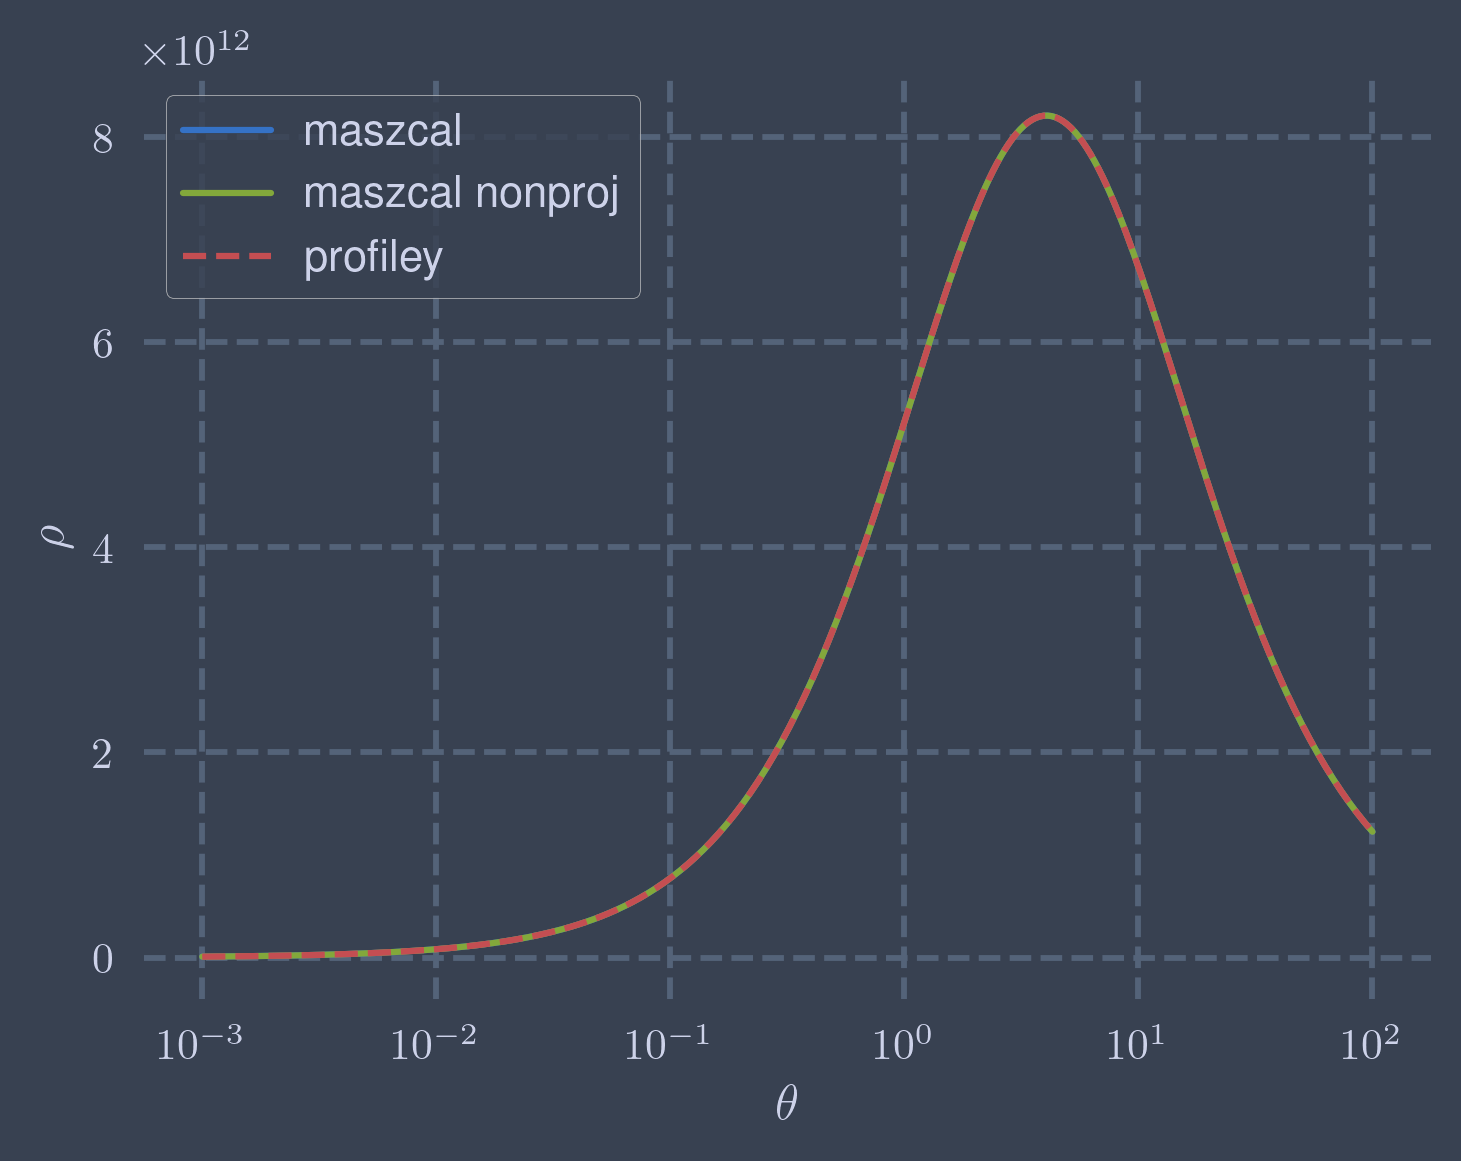

In [116]:
to_arcmin = 1/from_arcmin
plt.plot(thetas*to_arcmin, rs**2 * rhos, label='maszcal')
plt.plot(thetas*to_arcmin, rs**2 * rhos_, label='maszcal nonproj')
plt.plot(thetas*to_arcmin, rs**2 * rhos_profiley, label='profiley', linestyle='--')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\rho$')
plt.legend(loc='best')
plt.xscale('log')
#plt.ylabel(r'$\kappa_{\mathrm{maszcal}}/\kappa_{\mathrm{profiley}}$')
plt.gcf().set_size_inches(5, 4)

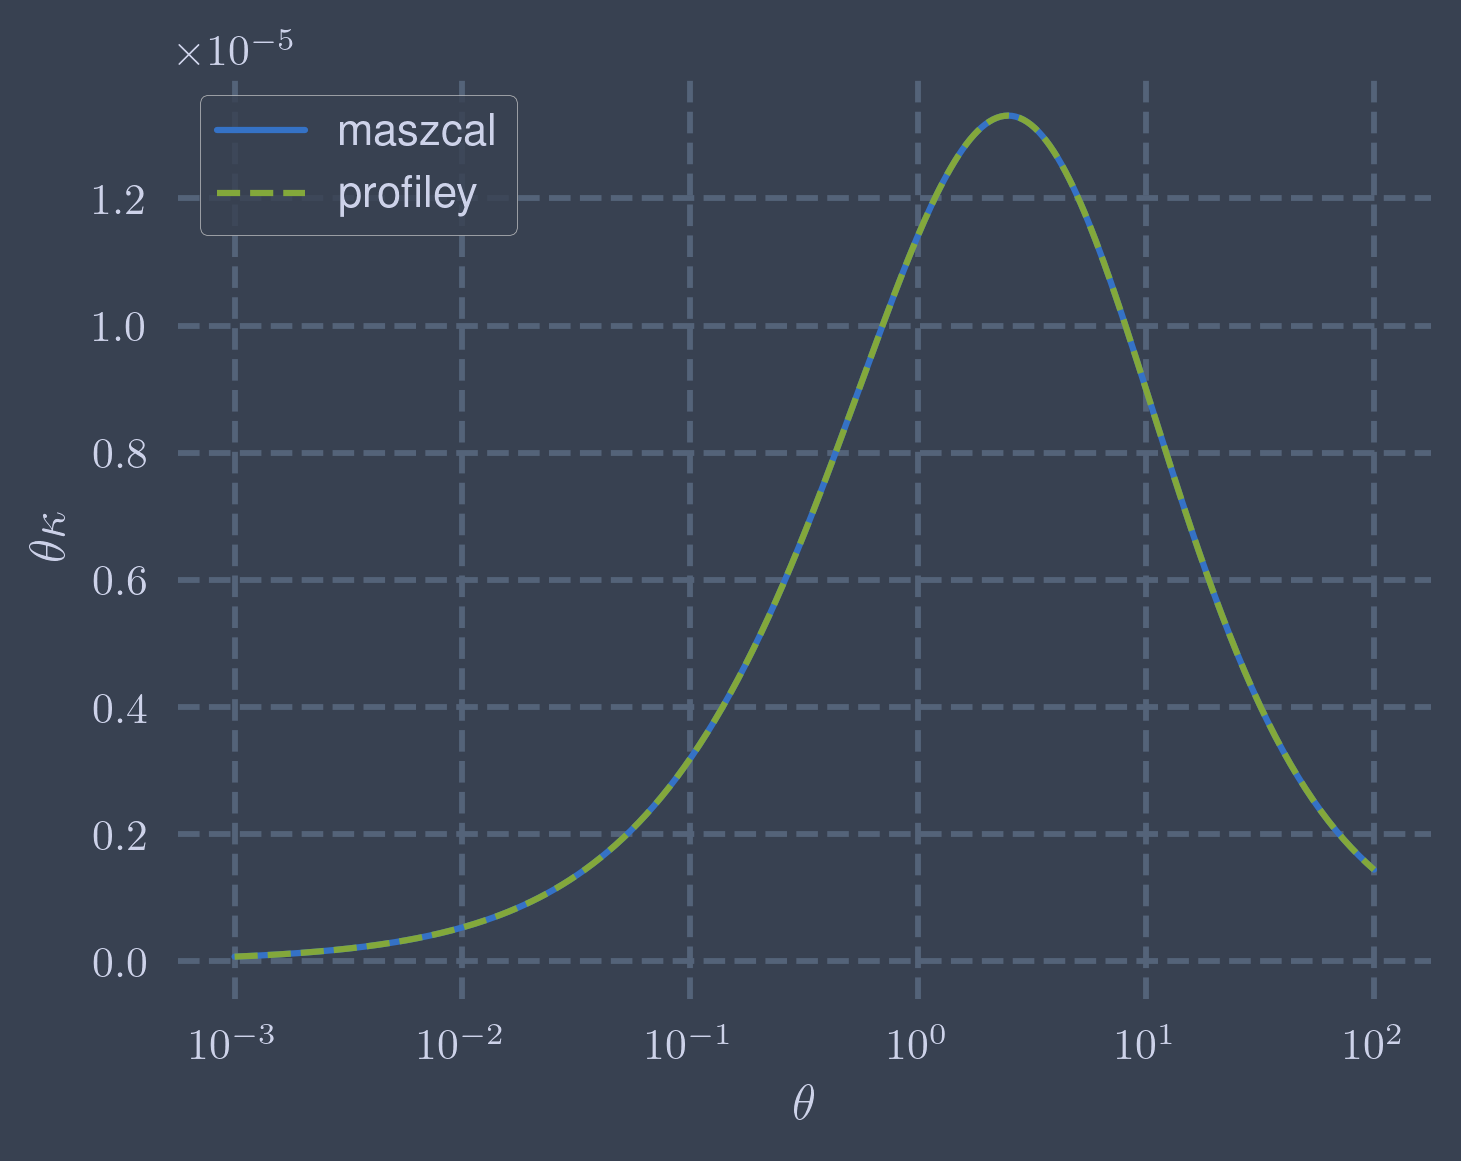

In [117]:
to_arcmin = 1/from_arcmin
plt.plot(thetas*to_arcmin, thetas*kappas, label='maszcal')
#plt.plot(thetas*to_arcmin, thetas*kappa__, label='maszcal radial')
plt.plot(thetas*to_arcmin, thetas*kappa_profiley, label='profiley', linestyle='--')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\theta \kappa$')
plt.legend(loc='best')
plt.xscale('log')
#plt.ylabel(r'$\kappa_{\mathrm{maszcal}}/\kappa_{\mathrm{profiley}}$')
plt.gcf().set_size_inches(5, 4)

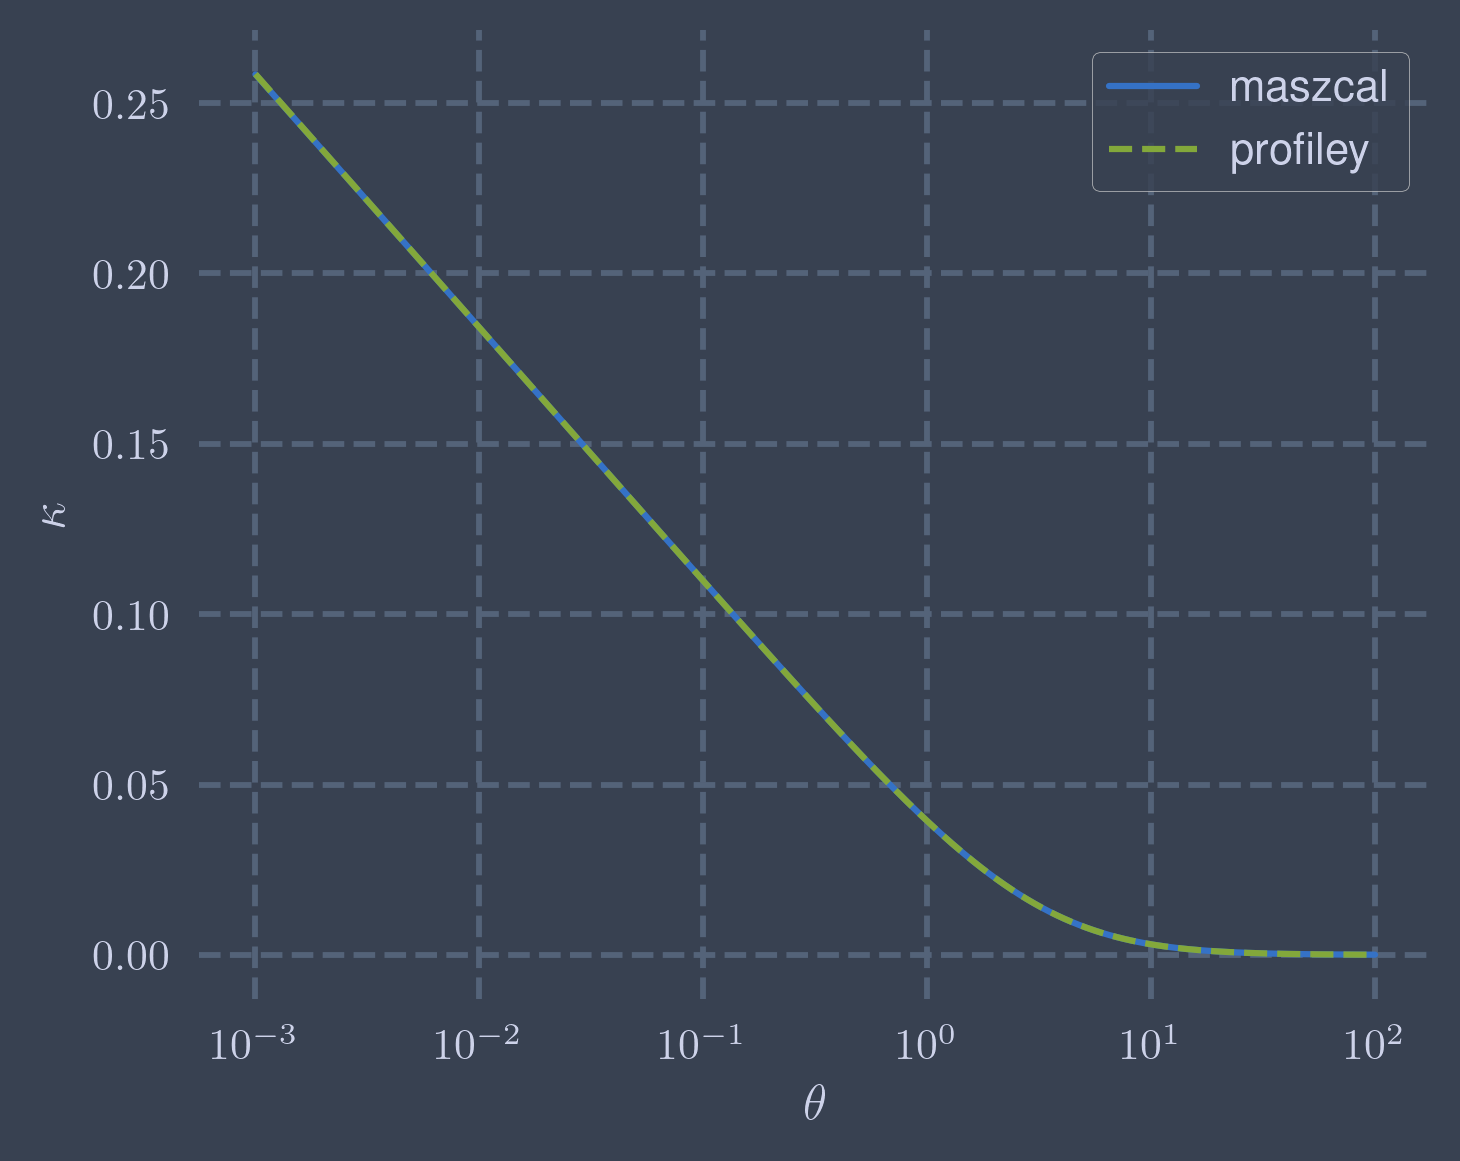

In [118]:
to_arcmin = 1/from_arcmin
plt.plot(thetas*to_arcmin, kappas, label='maszcal')
#plt.plot(thetas*to_arcmin, thetas*kappa__, label='maszcal radial')
plt.plot(thetas*to_arcmin, kappa_profiley, label='profiley', linestyle='--')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\kappa$')
plt.legend(loc='best')
plt.xscale('log')
#plt.ylabel(r'$\kappa_{\mathrm{maszcal}}/\kappa_{\mathrm{profiley}}$')
plt.gcf().set_size_inches(5, 4)

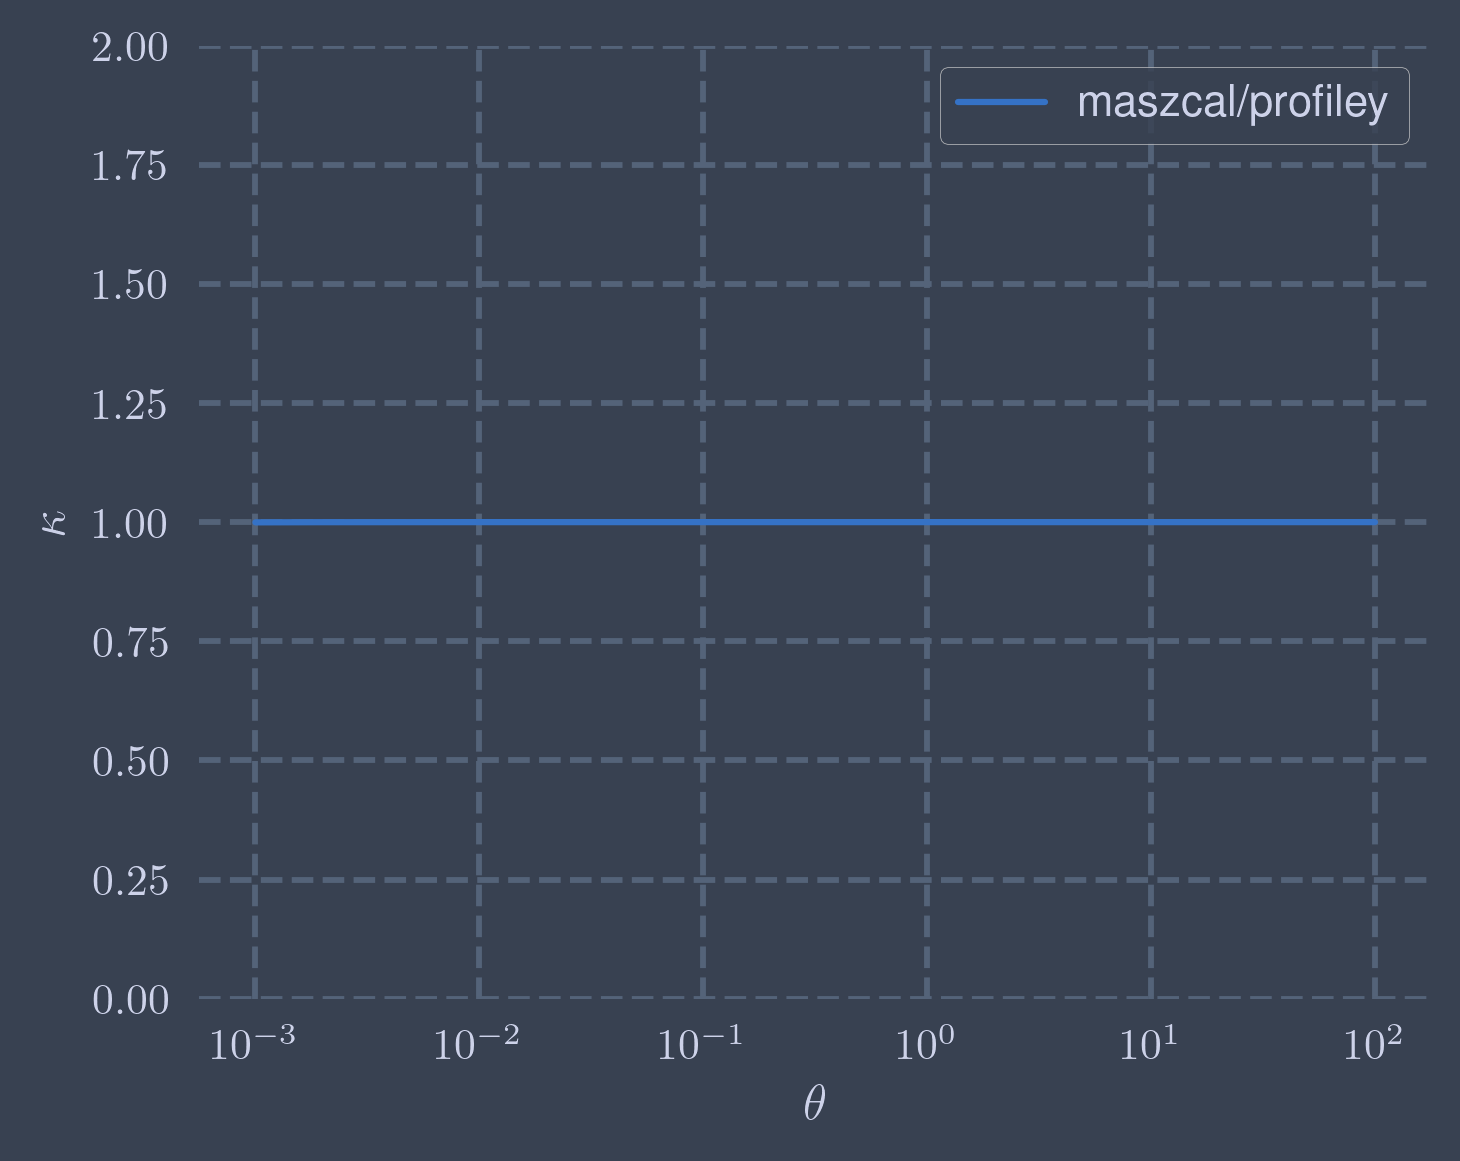

In [119]:
to_arcmin = 1/from_arcmin
plt.plot(thetas*to_arcmin, kappas/kappa_profiley, label='maszcal/profiley')
plt.ylim((0, 2))
#plt.plot(thetas*to_arcmin, thetas*kappa__, label='maszcal radial')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\kappa$')
plt.legend(loc='best')
plt.xscale('log')
#plt.ylabel(r'$\kappa_{\mathrm{maszcal}}/\kappa_{\mathrm{profiley}}$')
plt.gcf().set_size_inches(5, 4)

In [100]:
(kappas/kappa_profiley).mean()

0.9531793811515744

In [101]:
cosmo_params = maszcal.cosmology.CosmoParams()
(maszcal.cosmology.SigmaCrit(cosmo_params, comoving=True).sdc(z_source=1100, z_lens=z)
 / maszcal.cosmology.SigmaCrit(cosmo_params, comoving=False).sdc(z_source=1100, z_lens=z))

array([0.89047195])